In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt
import gdown
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

In [2]:
import gdown

url = 'https://drive.google.com/uc?id=1lABUY5LjGAXwI_BEm2Uj35xOz5_ToO5y'
output = 'Dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1lABUY5LjGAXwI_BEm2Uj35xOz5_ToO5y
To: /content/Dataset.zip
100%|██████████| 197M/197M [00:02<00:00, 73.0MB/s]


'Dataset.zip'

In [3]:
!unzip Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Preprocessed Dataset/val/altered_frames_cropped/r7B491zbxnw_0_pXJ6HOsm_iY_0.avi_frame_690.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/s8CuBT-MDYE_4_sZqIjquRfck_8.avi_frame_150.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/szxR2kMIWtI_0_saQyF1FPiqw_0.avi_frame_270.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/qpBoMZ8mAiQ_2_qpe2zydDOBM_0.avi_frame_210.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/wTsoXbhr0N8_4_wnx2fsN9WP0_1.avi_frame_360.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/wedLZCKQSrM_2_uvxJpaN72WQ_2.avi_frame_60.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/rBgM58w-gvM_1_pd8-LGKVGWQ_3.avi_frame_540.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/sZDvg03saDA_4_sZDvg03saDA_4.avi_frame_360.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/wedLZCKQSrM_2_uvx

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to the input size of the model
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(root='Preprocessed Dataset/train', transform=transform)
val_dataset = datasets.ImageFolder(root='Preprocessed Dataset/val', transform=transform)
test_dataset = datasets.ImageFolder(root='Preprocessed Dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
def check_data_loader_dim(loader):
    # Checking the dataset
    for images, labels in loader:
        print('Image batch dimensions:', images.shape)
        print('Image label dimensions:', labels.shape)
        break

check_data_loader_dim(train_loader)
check_data_loader_dim(val_loader)
check_data_loader_dim(test_loader)

Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])


In [6]:
# Load the pre-trained AlexNet model
model = models.alexnet(pretrained=True)

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer (classifier) for binary classification
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, 1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 144MB/s]


In [7]:
from tqdm.auto import tqdm
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cpu'):
    model.to(device)
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            if model.training and isinstance(outputs, tuple):
                # Inception model outputs a tuple of (main output, auxiliary output) during training
                main_output, aux_output = outputs
                loss1 = criterion(main_output, labels.view(-1, 1).float())
                loss2 = criterion(aux_output, labels.view(-1, 1).float())
                loss = loss1 + 0.4 * loss2  # Scale the auxiliary output loss
                preds = torch.sigmoid(main_output) > 0.5  # Apply sigmoid only to the main output
            else:
                # During evaluation and for other models, use the single output
                loss = criterion(outputs, labels.view(-1, 1).float())
                preds = torch.sigmoid(outputs) > 0.5  # Apply sigmoid to the output

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.view(-1, 1).data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation Phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch"):
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass for validation
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    # Only use the main output for validation
                    outputs, _ = outputs

                loss = criterion(outputs, labels.view(-1, 1).float())
                running_loss += loss.item() * inputs.size(0)

                preds = torch.sigmoid(outputs) > 0.5
                running_corrects += torch.sum(preds == labels.view(-1, 1).data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        print(f'Validation Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

    return model, (train_losses, train_accuracies, val_losses, val_accuracies)

In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model, metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device=device)

Epoch 1/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 1/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 1/25
Train Loss: 0.6283 Acc: 0.6467
Validation Loss: 0.6673 Acc: 0.6148


Epoch 2/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 2/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 2/25
Train Loss: 0.6081 Acc: 0.6701
Validation Loss: 0.6286 Acc: 0.6488


Epoch 3/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 3/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 3/25
Train Loss: 0.6038 Acc: 0.6737
Validation Loss: 0.5804 Acc: 0.6956


Epoch 4/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 4/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 4/25
Train Loss: 0.6039 Acc: 0.6736
Validation Loss: 0.6403 Acc: 0.6345


Epoch 5/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 5/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 5/25
Train Loss: 0.6071 Acc: 0.6722
Validation Loss: 0.6164 Acc: 0.6591


Epoch 6/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 6/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 6/25
Train Loss: 0.5995 Acc: 0.6814
Validation Loss: 0.5543 Acc: 0.7272


Epoch 7/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 7/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 7/25
Train Loss: 0.6032 Acc: 0.6770
Validation Loss: 0.5715 Acc: 0.7013


Epoch 8/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 8/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 8/25
Train Loss: 0.6063 Acc: 0.6760
Validation Loss: 0.5813 Acc: 0.6910


Epoch 9/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 9/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 9/25
Train Loss: 0.5989 Acc: 0.6800
Validation Loss: 0.5749 Acc: 0.7020


Epoch 10/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 10/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 10/25
Train Loss: 0.5972 Acc: 0.6815
Validation Loss: 0.5534 Acc: 0.7244


Epoch 11/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 11/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 11/25
Train Loss: 0.6028 Acc: 0.6778
Validation Loss: 0.5595 Acc: 0.7045


Epoch 12/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 12/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 12/25
Train Loss: 0.6033 Acc: 0.6759
Validation Loss: 0.5760 Acc: 0.6935


Epoch 13/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 13/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 13/25
Train Loss: 0.5970 Acc: 0.6822
Validation Loss: 0.6340 Acc: 0.6579


Epoch 14/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 14/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 14/25
Train Loss: 0.6074 Acc: 0.6730
Validation Loss: 0.6844 Acc: 0.6200


Epoch 15/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 15/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 15/25
Train Loss: 0.6036 Acc: 0.6776
Validation Loss: 0.5687 Acc: 0.7097


Epoch 16/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 16/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 16/25
Train Loss: 0.5996 Acc: 0.6827
Validation Loss: 0.5943 Acc: 0.6780


Epoch 17/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 17/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 17/25
Train Loss: 0.6021 Acc: 0.6752
Validation Loss: 0.5808 Acc: 0.6952


Epoch 18/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 18/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 18/25
Train Loss: 0.5991 Acc: 0.6799
Validation Loss: 0.5803 Acc: 0.6971


Epoch 19/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 19/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 19/25
Train Loss: 0.5943 Acc: 0.6794
Validation Loss: 0.5660 Acc: 0.7103


Epoch 20/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 20/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 20/25
Train Loss: 0.5983 Acc: 0.6801
Validation Loss: 0.5845 Acc: 0.6852


Epoch 21/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 21/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 21/25
Train Loss: 0.5941 Acc: 0.6846
Validation Loss: 0.5766 Acc: 0.7009


Epoch 22/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 22/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 22/25
Train Loss: 0.6000 Acc: 0.6799
Validation Loss: 0.6372 Acc: 0.6591


Epoch 23/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 23/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 23/25
Train Loss: 0.5997 Acc: 0.6819
Validation Loss: 0.5784 Acc: 0.6967


Epoch 24/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 24/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 24/25
Train Loss: 0.6019 Acc: 0.6781
Validation Loss: 0.5653 Acc: 0.7072


Epoch 25/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 25/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 25/25
Train Loss: 0.5969 Acc: 0.6833
Validation Loss: 0.5740 Acc: 0.6980


In [10]:
train_accuracy = [accuracy.cpu().item() for accuracy in metrics[1]]
val_accuracy = [accuracy.cpu().item() for accuracy in metrics[3]]

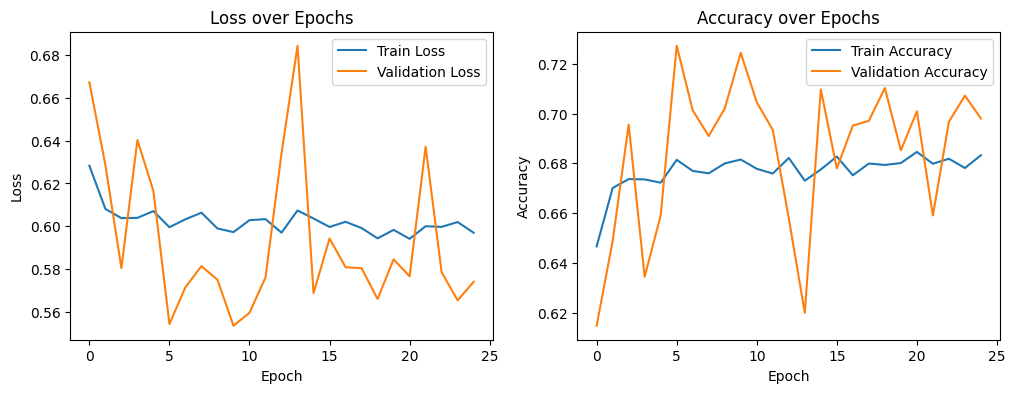

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(metrics[0], label='Train Loss')
plt.plot(metrics[2], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [12]:
torch.save(trained_model, 'Alexnet_model.pth')

In [13]:
class_names = train_dataset.classes

In [14]:
# Load the entire model
trained_model = torch.load('Alexnet_model.pth')

# Set to evaluation mode for inference
trained_model.eval()

# Move model to the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [15]:
trained_model.eval()

test_loss = 0
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for data, target in test_loader:
        # Moving data to the same device as model
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = trained_model(data)

        # Compute the loss
        test_loss += criterion(output, target.view(-1, 1).float()).item()

        # Convert output probabilities to predicted class
        preds = output > 0.0

        # Count correct predictions
        correct += torch.sum(preds == target.view(-1, 1).data).item()
        total += target.size(0)

# Calculate average loss and accuracy
test_loss /= len(test_loader.dataset)
test_accuracy = correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.0183, Test Accuracy: 0.6980


In [16]:
trained_model.eval()

# Lists to store actual and predicted labels
actuals = []
predictions = []

# Iterate over the test_loader
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Get predictions from the model
    with torch.no_grad():
        outputs = trained_model(images)

    # Apply sigmoid and round to get the binary class
    predicted_labels = torch.round(torch.sigmoid(outputs)).squeeze()

    # Store the true and predicted labels
    actuals.extend(labels.cpu().numpy())
    predictions.extend(predicted_labels.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(actuals, predictions)

# Calculate precision, recall, f1-score, and support
precision, recall, f1, _ = precision_recall_fscore_support(actuals, predictions, average='binary')

# Calculate accuracy
accuracy = accuracy_score(actuals, predictions)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)

print("\nAccuracy: {:.2f}%".format(accuracy * 100))
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Confusion Matrix:
[[2185  512]
 [1117 1580]]

Accuracy: 69.80%
Precision: 0.7552581261950286
Recall: 0.585836114200964
F1 Score: 0.6598454792232199
